In [1]:
import os
from glob import glob
import hashlib
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from copy import deepcopy
import ipynbname
import matplotlib.pyplot as plt
import shap
from datetime import datetime
import re

# Constants
EXPERIMENT_NAME = "nursing_home"
DATA_PATH = f"..{os.sep}data{os.sep}"

In [2]:
current_time = datetime.now()
print("Current time is:",current_time)

nb_fname = ipynbname.name()
print("File:",nb_fname)

experiment_number = int(re.findall(r'\d+', nb_fname)[0])
print(f"Experiment Number: {experiment_number}")  # Output: 01

Current time is: 2024-12-10 17:29:40.159732
File: machine_learning_experiment02
Experiment Number: 2


In [3]:
# Function to generate a consistent hash number for a given file name
def generate_hash_number(file_name):
    """
    Generates a consistent hash number based on the file name.
    
    Args:
        file_name (str): The file name to hash.
    
    Returns:
        int: A 32-bit hash number.
    """
    # Create an MD5 hash object
    hash_obj = hashlib.md5()
    
    # Update the hash object with the file name, encoded to bytes
    hash_obj.update(file_name.encode())

    # Convert the hash to an integer and ensure the range fits 32-bit
    return int(hash_obj.hexdigest(), 16) % (2**32)

# Generate experiment seed from experiment name
initial_seed = generate_hash_number(EXPERIMENT_NAME)
print(f"Experiment Name: {EXPERIMENT_NAME}, Initial Seed: {initial_seed}")

Experiment Name: nursing_home, Initial Seed: 127573839


In [4]:
# Set the seed for reproducibility
np.random.seed(initial_seed)

# Generate a list of 5 random integers in the range of 32-bit integers
random_integers_list = np.random.randint(low=0, high=2**31 - 1, size=10).tolist()
print("Random Integers List:", random_integers_list)
seed = random_integers_list[experiment_number-1]
# Load clinical microbiome data
df_path = glob(f'{DATA_PATH}*clinical_microbiome_df*')[0]
print(f"Data File Path: {df_path}")

clinical_microbiome_df = pd.read_csv(df_path)
print("Clinical Microbiome Data Loaded.")

# Display value counts for the 'Alzheimers' column
alzheimers_counts = clinical_microbiome_df['Alzheimers'].value_counts()
alzheimers_counts_normalized = clinical_microbiome_df['Alzheimers'].value_counts(normalize=True)

print("Alzheimers Counts:\n", alzheimers_counts)
print("Normalized Alzheimers Counts:\n", alzheimers_counts_normalized)
print(f"Seed in this experiment: {seed}")

Random Integers List: [315491657, 135304577, 1572185508, 1029933563, 1950160822, 563269619, 1573902777, 513873336, 442822283, 1770168448]
Data File Path: ../data/clinical_microbiome_df.csv
Clinical Microbiome Data Loaded.
Alzheimers Counts:
 Alzheimers
0.0    225
1.0    110
Name: count, dtype: int64
Normalized Alzheimers Counts:
 Alzheimers
0.0    0.671642
1.0    0.328358
Name: proportion, dtype: float64
Seed in this experiment: 135304577


In [5]:
clinical_microbiome_df["Dementia Other"].value_counts()

Dementia Other
0    335
Name: count, dtype: int64

In [6]:
clinical_microbiome_df = clinical_microbiome_df[clinical_microbiome_df["Dementia Other"] != 1]
# Display value counts for the 'Alzheimers' column
alzheimers_counts = clinical_microbiome_df['Alzheimers'].value_counts()
alzheimers_counts_normalized = clinical_microbiome_df['Alzheimers'].value_counts(normalize=True)
print("Alzheimers Counts:\n", alzheimers_counts)
print("Normalized Alzheimers Counts:\n", alzheimers_counts_normalized)

Alzheimers Counts:
 Alzheimers
0.0    225
1.0    110
Name: count, dtype: int64
Normalized Alzheimers Counts:
 Alzheimers
0.0    0.671642
1.0    0.328358
Name: proportion, dtype: float64


In [7]:
clinical_summaries_df = pd.read_csv(glob(f"..{os.sep}data{os.sep}clinical_summaries_df*")[0])
clinical_summaries_df

,Feature,Description,Group Characteristics,Summary
0,Sample ID,Unique identifier for biological or clinical s...,Study Identification,### Clinical Feature Summary\n\n#### Feature: ...
1,study_id,Identifier for the specific study or research ...,Study Identification,"### Clinical Feature Definitions, Scope, and R..."
2,day,Day of data collection or relevant event.,Temporal Information,### Clinical Feature Summary for Alzheimer's D...
3,Date Sample,Date when the sample was collected.,Temporal Information,### Clinical Feature Summary\n\n#### Feature: ...
4,age,Age of the participant.,Demographic Information,### Clinical Feature Summary: Age\n\n**Definit...
...,...,...,...,...
98,Severe Liver disease,Advanced liver disease diagnosis.,Hepatic Condition,### Clinical Feature: Severe Liver Disease\n\n...
99,ostomy,Presence of an ostomy.,Surgical History,### Clinical Feature: Ostomy\n\n**Definition:*...
100,Alzheimers,Diagnosis of Alzheimer’s disease.,Neurological Condition,### Clinical Feature Summary: Alzheimer's Dise...
101,Dementia Other,Other forms of dementia.,Neurological Condition,### Clinical Feature: Dementia Other\n\n**Defi...


In [8]:
clinical_summaries_df['Feature'].tolist()[:5]

['Sample ID', 'study_id', 'day', 'Date Sample', 'age']

In [9]:
clinical_summaries_df[['Feature']][clinical_summaries_df['Feature'].str.startswith(('c', 'C'))]

,Feature
10,clinical_frailty_scale
16,cholinesterase inhibitors
17,Calcium-channel blockers
58,Calcium Channel Modulators
59,Carbonic Anhydrase Inhibitor
60,Carboxamides
71,Chemotherapy Medication
81,COPD
86,Congestive heart failure
88,Cerebrovascular disease: CVA with mild or no r...


In [10]:
bacteria_df = pd.read_csv(glob(f"..{os.sep}data{os.sep}bacteria_df*")[0])
bacteria_df.species_name.tolist()[:5]

['Faecalibacterium_prausnitzii',
 'Fusicatenibacter_saccharivorans',
 'Eubacterium_siraeum',
 'Gemmiger_formicilis',
 'Eubacterium_rectale']

In [11]:
set(bacteria_df.species_name.tolist()[:5])

{'Eubacterium_rectale',
 'Eubacterium_siraeum',
 'Faecalibacterium_prausnitzii',
 'Fusicatenibacter_saccharivorans',
 'Gemmiger_formicilis'}

In [12]:
clinical_microbiome_df["Dementia Other"].value_counts()

Dementia Other
0    335
Name: count, dtype: int64

In [13]:
import os
from math import ceil
from pynvml import nvmlInit, nvmlDeviceGetCount

# Function to get the number of GPUs available
def get_num_gpus():
    try:
        nvmlInit()
        return nvmlDeviceGetCount()
    except Exception as e:
        print(f"Error accessing NVML: {e}")
        return 0

# Function to list all .ipynb files in the current directory
def get_notebook_files():
    return [f for f in os.listdir('.') if f.endswith('.ipynb')]

# Function to evenly distribute files across GPUs
def distribute_files_evenly(files, num_gpus):
    """
    Distributes files evenly across all available GPUs.
    
    Args:
        files (list): List of file names to distribute.
        num_gpus (int): Number of GPUs available.
        
    Returns:
        dict: Distribution of files per GPU.
    """
    distribution = {f"cuda:{i}": [] for i in range(num_gpus)}
    for idx, file in enumerate(files):
        # Assign each file to a GPU in round-robin fashion
        gpu_id = idx % num_gpus
        distribution[f"cuda:{gpu_id}"].append(file)
    return distribution

# Function to get GPU ID for a specific notebook file
def get_gpu_for_file(nb_fname, file_distribution):
    """
    Finds the GPU ID for a given notebook file based on the distribution.
    
    Args:
        nb_fname (str): Notebook file name to find the GPU for.
        file_distribution (dict): Distribution of files per GPU.
    
    Returns:
        str: GPU ID (e.g., "cuda:0") or "Unassigned" if the file is not found.
    """
    for gpu, files in file_distribution.items():
        if nb_fname in files:
            return gpu
    return "cpu"

# Main logic for the notebook
def assign_notebooks_to_gpus():
    # Get the number of GPUs
    num_gpus = get_num_gpus()
    if num_gpus == 0:
        print("No GPUs available. Using CPU for all tasks.")
        return {"cpu": get_notebook_files()}
    
    # Get the list of .ipynb files
    notebook_files = get_notebook_files()
    if not notebook_files:
        print("No .ipynb files found in the current directory.")
        return {}
    
    # Evenly distribute files across GPUs
    file_distribution = distribute_files_evenly(notebook_files, num_gpus)
    
    # Display the distribution in the notebook
    for gpu, files in file_distribution.items():
        print(f"{gpu}: {files}")
    
    return file_distribution

# Run the assignment logic
file_distribution = assign_notebooks_to_gpus()

# Get the GPU ID for the specific notebook file
device = get_gpu_for_file(f"{nb_fname}.ipynb", file_distribution)

print(f"Initial seed: {initial_seed}")
print(f"Random Integers List: {random_integers_list}")
# Print the result
print(f"Notebook '{nb_fname}.ipynb' is assigned to device: {device} with seed {seed}.")

cuda:0: ['machine_learning_experiment03.ipynb', 'machine_learning_experiment06.ipynb', 'machine_learning_experiment08.ipynb']
cuda:1: ['machine_learning_experiment09.ipynb', 'machine_learning_experiment07.ipynb', 'machine_learning_experiment10.ipynb']
cuda:2: ['machine_learning_experiment02.ipynb', 'machine_learning_experiment04.ipynb']
cuda:3: ['machine_learning_experiment05.ipynb', 'machine_learning_experiment01.ipynb']
Initial seed: 127573839
Random Integers List: [315491657, 135304577, 1572185508, 1029933563, 1950160822, 563269619, 1573902777, 513873336, 442822283, 1770168448]
Notebook 'machine_learning_experiment02.ipynb' is assigned to device: cuda:2 with seed 135304577.


Experiment number: 2 | Seed number: 135304577
No overlap Study ID found.
No overlap Sample ID found.


[I 2024-12-10 17:29:41,234] A new study created in memory with name: no-name-5bfa68ad-9b90-4208-81ac-3fd6ca65b249


Seed in the model 135304577 on Device cuda:2


[I 2024-12-10 17:29:41,922] Trial 0 finished with value: 0.6499083529719821 and parameters: {'threshold': 'mean', 'max_features': 321, 'norm_order': 2, 'learning_rate': 0.3639076272307053, 'max_depth': 14, 'min_child_weight': 6, 'subsample': 0.8592345688912018, 'colsample_bytree': 0.8096328200674565, 'gamma': 5.308357459655762, 'reg_alpha': 8.55499264026806, 'reg_lambda': 4.4609903817077505, 'n_estimators': 89}. Best is trial 0 with value: 0.6499083529719821.


Seed in the model 135304577 on Device cuda:2


[I 2024-12-10 17:29:42,286] Trial 1 finished with value: 0.6695688373476063 and parameters: {'threshold': 'mean', 'max_features': 254, 'norm_order': 2, 'learning_rate': 0.09538825792940898, 'max_depth': 4, 'min_child_weight': 7, 'subsample': 0.6482811324098423, 'colsample_bytree': 0.7423611082710702, 'gamma': 9.49850482657768, 'reg_alpha': 2.1642839515320333, 'reg_lambda': 8.017181318302116, 'n_estimators': 74}. Best is trial 1 with value: 0.6695688373476063.


Seed in the model 135304577 on Device cuda:2


[I 2024-12-10 17:29:42,703] Trial 2 finished with value: 0.7498375568551007 and parameters: {'threshold': '0.5*mean', 'max_features': 966, 'norm_order': 1, 'learning_rate': 0.3072517886162903, 'max_depth': 28, 'min_child_weight': 6, 'subsample': 0.6917596375721409, 'colsample_bytree': 0.8103809378645829, 'gamma': 4.947004489450687, 'reg_alpha': 0.27965190530846007, 'reg_lambda': 6.997410433154872, 'n_estimators': 158}. Best is trial 2 with value: 0.7498375568551007.


Seed in the model 135304577 on Device cuda:2


[I 2024-12-10 17:29:43,121] Trial 3 finished with value: 0.7153569594247561 and parameters: {'threshold': 'very_low', 'max_features': 833, 'norm_order': 1, 'learning_rate': 0.40866872777301033, 'max_depth': 20, 'min_child_weight': 7, 'subsample': 0.8096636745551471, 'colsample_bytree': 0.5731083317959527, 'gamma': 6.10067621720908, 'reg_alpha': 1.1798447327875916, 'reg_lambda': 0.2805427091758239, 'n_estimators': 164}. Best is trial 2 with value: 0.7498375568551007.


Seed in the model 135304577 on Device cuda:2


[I 2024-12-10 17:29:43,628] Trial 4 finished with value: 0.6844025773245374 and parameters: {'threshold': 'very_low', 'max_features': 168, 'norm_order': 1, 'learning_rate': 0.24908704468553716, 'max_depth': 8, 'min_child_weight': 3, 'subsample': 0.5288603943040533, 'colsample_bytree': 0.7404638538764392, 'gamma': 3.19208503479399, 'reg_alpha': 5.888714226060287, 'reg_lambda': 7.375920272746085, 'n_estimators': 154}. Best is trial 2 with value: 0.7498375568551007.


Seed in the model 135304577 on Device cuda:2


[I 2024-12-10 17:29:43,999] Trial 5 finished with value: 0.7680580762250453 and parameters: {'threshold': 'median', 'max_features': 901, 'norm_order': 1, 'learning_rate': 0.22240101242237484, 'max_depth': 12, 'min_child_weight': 1, 'subsample': 0.9173018550396721, 'colsample_bytree': 0.7500786728504119, 'gamma': 1.1167094954277246, 'reg_alpha': 4.132707056490005, 'reg_lambda': 4.280353967195326, 'n_estimators': 126}. Best is trial 5 with value: 0.7680580762250453.


Seed in the model 135304577 on Device cuda:2


[I 2024-12-10 17:29:44,361] Trial 6 finished with value: 0.6824489795918368 and parameters: {'threshold': '1.5*mean', 'max_features': 119, 'norm_order': 2, 'learning_rate': 0.4665344222158263, 'max_depth': 26, 'min_child_weight': 1, 'subsample': 0.7898825798079321, 'colsample_bytree': 0.7814697152493605, 'gamma': 6.084013225438099, 'reg_alpha': 8.91838922982378, 'reg_lambda': 4.172793322392168, 'n_estimators': 75}. Best is trial 5 with value: 0.7680580762250453.


Seed in the model 135304577 on Device cuda:2


[I 2024-12-10 17:29:44,680] Trial 7 finished with value: 0.6257575757575757 and parameters: {'threshold': 'median', 'max_features': 798, 'norm_order': 1, 'learning_rate': 0.1605763865247862, 'max_depth': 16, 'min_child_weight': 9, 'subsample': 0.9915889464061571, 'colsample_bytree': 0.6655878608520909, 'gamma': 9.790300119541403, 'reg_alpha': 5.682039916117738, 'reg_lambda': 3.265817945520173, 'n_estimators': 58}. Best is trial 5 with value: 0.7680580762250453.


Seed in the model 135304577 on Device cuda:2


[I 2024-12-10 17:29:45,160] Trial 8 finished with value: 0.724633553580922 and parameters: {'threshold': '1.5*mean', 'max_features': 990, 'norm_order': 2, 'learning_rate': 0.23334283391530122, 'max_depth': 30, 'min_child_weight': 7, 'subsample': 0.9364038924571392, 'colsample_bytree': 0.9626804476472323, 'gamma': 5.524137169587858, 'reg_alpha': 0.8272920854358756, 'reg_lambda': 9.743119077116638, 'n_estimators': 235}. Best is trial 5 with value: 0.7680580762250453.


Seed in the model 135304577 on Device cuda:2


[I 2024-12-10 17:29:45,642] Trial 9 finished with value: 0.7710678210678211 and parameters: {'threshold': 'very_low', 'max_features': 89, 'norm_order': 1, 'learning_rate': 0.07615071433039382, 'max_depth': 21, 'min_child_weight': 3, 'subsample': 0.622028833743877, 'colsample_bytree': 0.8974224468281035, 'gamma': 7.263887437332311, 'reg_alpha': 0.7015134898057263, 'reg_lambda': 0.028750517431170852, 'n_estimators': 98}. Best is trial 9 with value: 0.7710678210678211.


Seed in the model 135304577 on Device cuda:2


[I 2024-12-10 17:29:46,635] Trial 10 finished with value: 0.7227216237028905 and parameters: {'threshold': 'very_low', 'max_features': 516, 'norm_order': 1, 'learning_rate': 0.02194241329624575, 'max_depth': 23, 'min_child_weight': 4, 'subsample': 0.5228696485098097, 'colsample_bytree': 0.9998895055148509, 'gamma': 7.79386860618682, 'reg_alpha': 3.144884827659898, 'reg_lambda': 0.5297010190141886, 'n_estimators': 297}. Best is trial 9 with value: 0.7710678210678211.


Seed in the model 135304577 on Device cuda:2


[I 2024-12-10 17:29:47,287] Trial 11 finished with value: 0.7821371610845295 and parameters: {'threshold': 'median', 'max_features': 588, 'norm_order': 1, 'learning_rate': 0.14579003353798442, 'max_depth': 12, 'min_child_weight': 1, 'subsample': 0.6288810793482094, 'colsample_bytree': 0.8949581954069561, 'gamma': 0.04376643972403205, 'reg_alpha': 3.9819328602727913, 'reg_lambda': 2.3554236490795066, 'n_estimators': 120}. Best is trial 11 with value: 0.7821371610845295.


Seed in the model 135304577 on Device cuda:2


[I 2024-12-10 17:29:47,903] Trial 12 finished with value: 0.768539647487016 and parameters: {'threshold': 'median', 'max_features': 585, 'norm_order': 1, 'learning_rate': 0.10552423690371417, 'max_depth': 20, 'min_child_weight': 3, 'subsample': 0.6089937549651663, 'colsample_bytree': 0.9255754908189544, 'gamma': 0.3073209823407206, 'reg_alpha': 7.337849706153506, 'reg_lambda': 2.121391232764711, 'n_estimators': 127}. Best is trial 11 with value: 0.7821371610845295.


Seed in the model 135304577 on Device cuda:2


[I 2024-12-10 17:29:48,422] Trial 13 finished with value: 0.17125382262996944 and parameters: {'threshold': '0.5*mean', 'max_features': 2, 'norm_order': 1, 'learning_rate': 0.037209184006202045, 'max_depth': 10, 'min_child_weight': 3, 'subsample': 0.6049102639536503, 'colsample_bytree': 0.8792194424600971, 'gamma': 2.8216128775043283, 'reg_alpha': 3.787794792767124, 'reg_lambda': 1.8705101502768215, 'n_estimators': 208}. Best is trial 11 with value: 0.7821371610845295.


Seed in the model 135304577 on Device cuda:2


[I 2024-12-10 17:29:48,876] Trial 14 finished with value: 0.7558788088692627 and parameters: {'threshold': 'median', 'max_features': 494, 'norm_order': 1, 'learning_rate': 0.14554971522465326, 'max_depth': 19, 'min_child_weight': 1, 'subsample': 0.7169791814975496, 'colsample_bytree': 0.870864140364194, 'gamma': 7.507772121355853, 'reg_alpha': 1.843840761512985, 'reg_lambda': 1.635812751151109, 'n_estimators': 111}. Best is trial 11 with value: 0.7821371610845295.


Seed in the model 135304577 on Device cuda:2


[I 2024-12-10 17:29:49,540] Trial 15 finished with value: 0.7601514200384257 and parameters: {'threshold': 'very_low', 'max_features': 681, 'norm_order': 1, 'learning_rate': 0.1748162362650198, 'max_depth': 6, 'min_child_weight': 4, 'subsample': 0.5724033910017094, 'colsample_bytree': 0.8895303560568475, 'gamma': 2.730408924363511, 'reg_alpha': 2.4561454218039573, 'reg_lambda': 2.8860708687638748, 'n_estimators': 201}. Best is trial 11 with value: 0.7821371610845295.


Seed in the model 135304577 on Device cuda:2


[I 2024-12-10 17:29:50,033] Trial 16 finished with value: 0.7467007237122179 and parameters: {'threshold': 'median', 'max_features': 422, 'norm_order': 1, 'learning_rate': 0.09385273150912146, 'max_depth': 23, 'min_child_weight': 2, 'subsample': 0.6722530583766553, 'colsample_bytree': 0.5249634037207723, 'gamma': 4.028082836647145, 'reg_alpha': 4.533416166234203, 'reg_lambda': 0.7925480051666975, 'n_estimators': 102}. Best is trial 11 with value: 0.7821371610845295.


Seed in the model 135304577 on Device cuda:2


[I 2024-12-10 17:29:50,594] Trial 17 finished with value: 0.6412046767238023 and parameters: {'threshold': 'very_low', 'max_features': 669, 'norm_order': 2, 'learning_rate': 0.05650117861548487, 'max_depth': 16, 'min_child_weight': 10, 'subsample': 0.740226024806929, 'colsample_bytree': 0.6598357194982375, 'gamma': 7.7164136376913355, 'reg_alpha': 6.924977332319783, 'reg_lambda': 5.8629411848995865, 'n_estimators': 137}. Best is trial 11 with value: 0.7821371610845295.


Seed in the model 135304577 on Device cuda:2


[I 2024-12-10 17:29:51,274] Trial 18 finished with value: 0.783091202582728 and parameters: {'threshold': 'mean', 'max_features': 427, 'norm_order': 1, 'learning_rate': 0.3161915570376789, 'max_depth': 11, 'min_child_weight': 4, 'subsample': 0.6325334029882943, 'colsample_bytree': 0.8446806898552032, 'gamma': 1.2612772010181783, 'reg_alpha': 3.351482679115339, 'reg_lambda': 3.1302220929542135, 'n_estimators': 199}. Best is trial 18 with value: 0.783091202582728.


Seed in the model 135304577 on Device cuda:2


[I 2024-12-10 17:29:51,775] Trial 19 finished with value: 0.742052166987456 and parameters: {'threshold': 'mean', 'max_features': 385, 'norm_order': 1, 'learning_rate': 0.3204548867985852, 'max_depth': 11, 'min_child_weight': 5, 'subsample': 0.5636763572046961, 'colsample_bytree': 0.8379324236813627, 'gamma': 1.0160964217172856, 'reg_alpha': 5.288594643701282, 'reg_lambda': 3.3046085217041643, 'n_estimators': 249}. Best is trial 18 with value: 0.783091202582728.


Seed in the model 135304577 on Device cuda:2


[I 2024-12-10 17:29:52,241] Trial 20 finished with value: 0.7652116402116401 and parameters: {'threshold': 'mean', 'max_features': 633, 'norm_order': 2, 'learning_rate': 0.3091285709702299, 'max_depth': 7, 'min_child_weight': 2, 'subsample': 0.775282377717688, 'colsample_bytree': 0.9459393214904597, 'gamma': 1.5890597527783576, 'reg_alpha': 3.159633756602513, 'reg_lambda': 6.221483698861093, 'n_estimators': 190}. Best is trial 18 with value: 0.783091202582728.


Seed in the model 135304577 on Device cuda:2


[I 2024-12-10 17:29:52,778] Trial 21 finished with value: 0.7973381730187538 and parameters: {'threshold': 'mean', 'max_features': 47, 'norm_order': 1, 'learning_rate': 0.1911081831344737, 'max_depth': 14, 'min_child_weight': 4, 'subsample': 0.6012374862489176, 'colsample_bytree': 0.9067160020804584, 'gamma': 0.2297615866568936, 'reg_alpha': 3.057691263337346, 'reg_lambda': 1.239235779003772, 'n_estimators': 233}. Best is trial 21 with value: 0.7973381730187538.


Seed in the model 135304577 on Device cuda:2


[I 2024-12-10 17:29:53,455] Trial 22 finished with value: 0.7720458553791887 and parameters: {'threshold': 'mean', 'max_features': 248, 'norm_order': 1, 'learning_rate': 0.1927962049350855, 'max_depth': 13, 'min_child_weight': 5, 'subsample': 0.6672458842707487, 'colsample_bytree': 0.8471428053108179, 'gamma': 0.1336122703254017, 'reg_alpha': 3.164929262530933, 'reg_lambda': 2.513618258661085, 'n_estimators': 244}. Best is trial 21 with value: 0.7973381730187538.


Seed in the model 135304577 on Device cuda:2


[I 2024-12-10 17:29:54,016] Trial 23 finished with value: 0.7453591606133979 and parameters: {'threshold': 'mean', 'max_features': 757, 'norm_order': 1, 'learning_rate': 0.2723994667160325, 'max_depth': 15, 'min_child_weight': 4, 'subsample': 0.5028056324182175, 'colsample_bytree': 0.9944732686522983, 'gamma': 1.9340162891060753, 'reg_alpha': 4.549204200167145, 'reg_lambda': 1.3868789901369305, 'n_estimators': 226}. Best is trial 21 with value: 0.7973381730187538.


Seed in the model 135304577 on Device cuda:2


[I 2024-12-10 17:29:54,839] Trial 24 finished with value: 0.8387445887445888 and parameters: {'threshold': 'mean', 'max_features': 436, 'norm_order': 1, 'learning_rate': 0.13798711204295003, 'max_depth': 10, 'min_child_weight': 2, 'subsample': 0.55773306203088, 'colsample_bytree': 0.9192136697321058, 'gamma': 0.03458717243131315, 'reg_alpha': 6.3701306826374005, 'reg_lambda': 3.628367721039625, 'n_estimators': 265}. Best is trial 24 with value: 0.8387445887445888.


Seed in the model 135304577 on Device cuda:2


[I 2024-12-10 17:29:55,233] Trial 25 finished with value: 0.728493979341437 and parameters: {'threshold': 'mean', 'max_features': 357, 'norm_order': 1, 'learning_rate': 0.39188814415631373, 'max_depth': 3, 'min_child_weight': 2, 'subsample': 0.5590423775704956, 'colsample_bytree': 0.9324987787949921, 'gamma': 2.235332059059031, 'reg_alpha': 6.677832461151385, 'reg_lambda': 5.284157041071163, 'n_estimators': 274}. Best is trial 24 with value: 0.8387445887445888.


Seed in the model 135304577 on Device cuda:2


[I 2024-12-10 17:29:55,754] Trial 26 finished with value: 0.7359985926023662 and parameters: {'threshold': 'mean', 'max_features': 459, 'norm_order': 1, 'learning_rate': 0.26895210128893215, 'max_depth': 9, 'min_child_weight': 4, 'subsample': 0.5726114640223265, 'colsample_bytree': 0.8380683335459455, 'gamma': 0.9301112573018708, 'reg_alpha': 8.010113841142815, 'reg_lambda': 3.585304567796444, 'n_estimators': 266}. Best is trial 24 with value: 0.8387445887445888.


Seed in the model 135304577 on Device cuda:2


[I 2024-12-10 17:29:56,115] Trial 27 finished with value: 0.0 and parameters: {'threshold': 'mean', 'max_features': 2, 'norm_order': 1, 'learning_rate': 0.20063247934197842, 'max_depth': 18, 'min_child_weight': 5, 'subsample': 0.7128330732358031, 'colsample_bytree': 0.9524129631044927, 'gamma': 3.8050778029149273, 'reg_alpha': 6.062744836198095, 'reg_lambda': 5.008760584438782, 'n_estimators': 290}. Best is trial 24 with value: 0.8387445887445888.


Seed in the model 135304577 on Device cuda:2


[I 2024-12-10 17:29:56,772] Trial 28 finished with value: 0.7753885717760923 and parameters: {'threshold': 'mean', 'max_features': 275, 'norm_order': 1, 'learning_rate': 0.12632824213779184, 'max_depth': 5, 'min_child_weight': 2, 'subsample': 0.5992321477932702, 'colsample_bytree': 0.6884047419680788, 'gamma': 0.997837079127244, 'reg_alpha': 5.043312650996004, 'reg_lambda': 1.0545898455929312, 'n_estimators': 219}. Best is trial 24 with value: 0.8387445887445888.


Seed in the model 135304577 on Device cuda:2


[I 2024-12-10 17:29:57,151] Trial 29 finished with value: 0.7240845365139151 and parameters: {'threshold': 'mean', 'max_features': 316, 'norm_order': 2, 'learning_rate': 0.33817154797339216, 'max_depth': 14, 'min_child_weight': 6, 'subsample': 0.8390020533374877, 'colsample_bytree': 0.7776600306713221, 'gamma': 1.9333293598852173, 'reg_alpha': 9.799644436222398, 'reg_lambda': 3.8751280572066737, 'n_estimators': 187}. Best is trial 24 with value: 0.8387445887445888.


Seed in the model 135304577 on Device cuda:2


[I 2024-12-10 17:29:57,819] Trial 30 finished with value: 0.8324514991181657 and parameters: {'threshold': '1.5*mean', 'max_features': 183, 'norm_order': 1, 'learning_rate': 0.36799722381808087, 'max_depth': 10, 'min_child_weight': 3, 'subsample': 0.5402466314684665, 'colsample_bytree': 0.8167281994123108, 'gamma': 0.47129436221803456, 'reg_alpha': 1.776287709872967, 'reg_lambda': 4.577707480269583, 'n_estimators': 267}. Best is trial 24 with value: 0.8387445887445888.


Seed in the model 135304577 on Device cuda:2


[I 2024-12-10 17:29:58,339] Trial 31 finished with value: 0.7986291486291486 and parameters: {'threshold': '1.5*mean', 'max_features': 191, 'norm_order': 1, 'learning_rate': 0.3713626496334648, 'max_depth': 10, 'min_child_weight': 3, 'subsample': 0.5351668137445919, 'colsample_bytree': 0.8221495456252667, 'gamma': 0.5205151914528694, 'reg_alpha': 1.7282125115621412, 'reg_lambda': 4.878499893491642, 'n_estimators': 260}. Best is trial 24 with value: 0.8387445887445888.


Seed in the model 135304577 on Device cuda:2


[I 2024-12-10 17:29:58,715] Trial 32 finished with value: 0.7324436447243464 and parameters: {'threshold': '1.5*mean', 'max_features': 186, 'norm_order': 1, 'learning_rate': 0.45932216085162675, 'max_depth': 9, 'min_child_weight': 3, 'subsample': 0.5442804923445047, 'colsample_bytree': 0.7874031984479384, 'gamma': 0.6089141931819758, 'reg_alpha': 2.1334309373702265, 'reg_lambda': 4.712126702296374, 'n_estimators': 262}. Best is trial 24 with value: 0.8387445887445888.


Seed in the model 135304577 on Device cuda:2


[I 2024-12-10 17:29:59,337] Trial 33 finished with value: 0.8526790819243649 and parameters: {'threshold': '1.5*mean', 'max_features': 65, 'norm_order': 1, 'learning_rate': 0.42589608254106337, 'max_depth': 14, 'min_child_weight': 2, 'subsample': 0.5334891674446822, 'colsample_bytree': 0.81019049524425, 'gamma': 0.0330912486914155, 'reg_alpha': 1.547437505911077, 'reg_lambda': 5.9022912056122045, 'n_estimators': 277}. Best is trial 33 with value: 0.8526790819243649.


Seed in the model 135304577 on Device cuda:2


[I 2024-12-10 17:29:59,823] Trial 34 finished with value: 0.7722048066875652 and parameters: {'threshold': '1.5*mean', 'max_features': 192, 'norm_order': 1, 'learning_rate': 0.4363147317257845, 'max_depth': 7, 'min_child_weight': 2, 'subsample': 0.5039971090650661, 'colsample_bytree': 0.8118167146250298, 'gamma': 1.5268371070162945, 'reg_alpha': 1.4561754533297067, 'reg_lambda': 5.829062693413734, 'n_estimators': 281}. Best is trial 33 with value: 0.8526790819243649.


Seed in the model 135304577 on Device cuda:2


[I 2024-12-10 17:30:00,601] Trial 35 finished with value: 0.8210042927024058 and parameters: {'threshold': '1.5*mean', 'max_features': 122, 'norm_order': 1, 'learning_rate': 0.49645758153695985, 'max_depth': 9, 'min_child_weight': 2, 'subsample': 0.5414779469779384, 'colsample_bytree': 0.7106568983410801, 'gamma': 0.6167346803480313, 'reg_alpha': 0.30937539750306486, 'reg_lambda': 6.614725257535822, 'n_estimators': 255}. Best is trial 33 with value: 0.8526790819243649.


Seed in the model 135304577 on Device cuda:2


[I 2024-12-10 17:30:01,058] Trial 36 finished with value: 0.7768922305764411 and parameters: {'threshold': '1.5*mean', 'max_features': 112, 'norm_order': 1, 'learning_rate': 0.4837757914340932, 'max_depth': 8, 'min_child_weight': 2, 'subsample': 0.5719206423152465, 'colsample_bytree': 0.7175815674336119, 'gamma': 2.5631387654826012, 'reg_alpha': 0.058908470148279435, 'reg_lambda': 8.211984743141844, 'n_estimators': 283}. Best is trial 33 with value: 0.8526790819243649.


Seed in the model 135304577 on Device cuda:2


[I 2024-12-10 17:30:01,531] Trial 37 finished with value: 0.7064176245210728 and parameters: {'threshold': '1.5*mean', 'max_features': 289, 'norm_order': 1, 'learning_rate': 0.4242806300815059, 'max_depth': 4, 'min_child_weight': 1, 'subsample': 0.5072444924859143, 'colsample_bytree': 0.7145292371943294, 'gamma': 3.538105028464069, 'reg_alpha': 0.9386422110167889, 'reg_lambda': 6.83779068740828, 'n_estimators': 255}. Best is trial 33 with value: 0.8526790819243649.


Seed in the model 135304577 on Device cuda:2


[I 2024-12-10 17:30:02,090] Trial 38 finished with value: 0.8713804713804714 and parameters: {'threshold': '1.5*mean', 'max_features': 237, 'norm_order': 2, 'learning_rate': 0.49941275476128466, 'max_depth': 13, 'min_child_weight': 1, 'subsample': 0.6613396337096931, 'colsample_bytree': 0.6196045020538405, 'gamma': 0.0036804476493738116, 'reg_alpha': 0.4788494069592739, 'reg_lambda': 7.108491023004643, 'n_estimators': 273}. Best is trial 38 with value: 0.8713804713804714.


Seed in the model 135304577 on Device cuda:2


[I 2024-12-10 17:30:02,702] Trial 39 finished with value: 0.8947038442501237 and parameters: {'threshold': '0.5*mean', 'max_features': 236, 'norm_order': 2, 'learning_rate': 0.4467347325797025, 'max_depth': 17, 'min_child_weight': 1, 'subsample': 0.6501382611693812, 'colsample_bytree': 0.5831604042347601, 'gamma': 0.03672378801917987, 'reg_alpha': 2.436452880995944, 'reg_lambda': 7.4690955864236726, 'n_estimators': 296}. Best is trial 39 with value: 0.8947038442501237.


Seed in the model 135304577 on Device cuda:2


[I 2024-12-10 17:30:03,218] Trial 40 finished with value: 0.7590116506372663 and parameters: {'threshold': '0.5*mean', 'max_features': 235, 'norm_order': 2, 'learning_rate': 0.44584439798866654, 'max_depth': 17, 'min_child_weight': 1, 'subsample': 0.6618029418586102, 'colsample_bytree': 0.5957189743228442, 'gamma': 4.897689268990823, 'reg_alpha': 2.524649843855535, 'reg_lambda': 7.860197896920615, 'n_estimators': 299}. Best is trial 39 with value: 0.8947038442501237.


Seed in the model 135304577 on Device cuda:2


[I 2024-12-10 17:30:04,091] Trial 41 finished with value: 0.8625199362041468 and parameters: {'threshold': '0.5*mean', 'max_features': 58, 'norm_order': 2, 'learning_rate': 0.39672831341035786, 'max_depth': 12, 'min_child_weight': 1, 'subsample': 0.6939266108668851, 'colsample_bytree': 0.5946149149615249, 'gamma': 0.02109840027815261, 'reg_alpha': 1.371734385907315, 'reg_lambda': 7.571548094760248, 'n_estimators': 273}. Best is trial 39 with value: 0.8947038442501237.


Seed in the model 135304577 on Device cuda:2


[I 2024-12-10 17:30:04,702] Trial 42 finished with value: 0.8176823176823177 and parameters: {'threshold': '0.5*mean', 'max_features': 65, 'norm_order': 2, 'learning_rate': 0.40305969226220434, 'max_depth': 13, 'min_child_weight': 1, 'subsample': 0.6962563432682437, 'colsample_bytree': 0.608264551187366, 'gamma': 1.5062036927757911, 'reg_alpha': 1.0871037187767305, 'reg_lambda': 8.875388127754269, 'n_estimators': 282}. Best is trial 39 with value: 0.8947038442501237.


Seed in the model 135304577 on Device cuda:2


[I 2024-12-10 17:30:05,145] Trial 43 finished with value: 0.6895902331320215 and parameters: {'threshold': '0.5*mean', 'max_features': 350, 'norm_order': 2, 'learning_rate': 0.46822260474056276, 'max_depth': 15, 'min_child_weight': 1, 'subsample': 0.7545998688388147, 'colsample_bytree': 0.5429012778729893, 'gamma': 8.906139078774032, 'reg_alpha': 0.5643827816987648, 'reg_lambda': 7.4954688818772395, 'n_estimators': 300}. Best is trial 39 with value: 0.8947038442501237.


Seed in the model 135304577 on Device cuda:2


[I 2024-12-10 17:30:05,704] Trial 44 finished with value: 0.7215956558061821 and parameters: {'threshold': '0.5*mean', 'max_features': 129, 'norm_order': 2, 'learning_rate': 0.4287891047021961, 'max_depth': 17, 'min_child_weight': 8, 'subsample': 0.6542153560260326, 'colsample_bytree': 0.6309274825273748, 'gamma': 0.8091787286694663, 'reg_alpha': 1.1917853481071825, 'reg_lambda': 8.22394218825417, 'n_estimators': 274}. Best is trial 39 with value: 0.8947038442501237.


Seed in the model 135304577 on Device cuda:2


[I 2024-12-10 17:30:06,398] Trial 45 finished with value: 0.8811422495633021 and parameters: {'threshold': '0.5*mean', 'max_features': 37, 'norm_order': 2, 'learning_rate': 0.4974951167809344, 'max_depth': 13, 'min_child_weight': 1, 'subsample': 0.6930193874992324, 'colsample_bytree': 0.5619679827830782, 'gamma': 0.03721589573950755, 'reg_alpha': 2.539507217443435, 'reg_lambda': 9.123593402227208, 'n_estimators': 242}. Best is trial 39 with value: 0.8947038442501237.


Seed in the model 135304577 on Device cuda:2


[I 2024-12-10 17:30:06,840] Trial 46 finished with value: 0.8091689627341293 and parameters: {'threshold': '0.5*mean', 'max_features': 42, 'norm_order': 2, 'learning_rate': 0.49996869508198255, 'max_depth': 12, 'min_child_weight': 1, 'subsample': 0.695519143856134, 'colsample_bytree': 0.5003505296288381, 'gamma': 1.81749468845659, 'reg_alpha': 2.597611327096393, 'reg_lambda': 9.302236322704042, 'n_estimators': 241}. Best is trial 39 with value: 0.8947038442501237.


Seed in the model 135304577 on Device cuda:2


[I 2024-12-10 17:30:07,581] Trial 47 finished with value: 0.8687366093026471 and parameters: {'threshold': '0.5*mean', 'max_features': 86, 'norm_order': 2, 'learning_rate': 0.47527803009366176, 'max_depth': 15, 'min_child_weight': 1, 'subsample': 0.7272255883136417, 'colsample_bytree': 0.5662743077995819, 'gamma': 0.021003077504246903, 'reg_alpha': 2.1102851885229836, 'reg_lambda': 8.774513229505553, 'n_estimators': 290}. Best is trial 39 with value: 0.8947038442501237.


Seed in the model 135304577 on Device cuda:2


[I 2024-12-10 17:30:08,012] Trial 48 finished with value: 0.8054882970137207 and parameters: {'threshold': '0.5*mean', 'max_features': 148, 'norm_order': 2, 'learning_rate': 0.4710905324720482, 'max_depth': 21, 'min_child_weight': 1, 'subsample': 0.7412216357417593, 'colsample_bytree': 0.5748491967224791, 'gamma': 1.2254230359693927, 'reg_alpha': 2.1109222655268756, 'reg_lambda': 9.97571188731717, 'n_estimators': 291}. Best is trial 39 with value: 0.8947038442501237.


Seed in the model 135304577 on Device cuda:2


[I 2024-12-10 17:30:08,500] Trial 49 finished with value: 0.6878121660232503 and parameters: {'threshold': '0.5*mean', 'max_features': 221, 'norm_order': 2, 'learning_rate': 0.45203478130682406, 'max_depth': 18, 'min_child_weight': 1, 'subsample': 0.7199815497675066, 'colsample_bytree': 0.5553476920557542, 'gamma': 6.461722575767343, 'reg_alpha': 3.613741754214082, 'reg_lambda': 8.9868558731025, 'n_estimators': 289}. Best is trial 39 with value: 0.8947038442501237.


Seed in the model 135304577 on Device cuda:2


[I 2024-12-10 17:30:08,816] Trial 50 finished with value: 0.7660758528683056 and parameters: {'threshold': '0.5*mean', 'max_features': 29, 'norm_order': 2, 'learning_rate': 0.48226899221316333, 'max_depth': 15, 'min_child_weight': 1, 'subsample': 0.82126434526898, 'colsample_bytree': 0.6343650306041072, 'gamma': 4.538370748550513, 'reg_alpha': 2.588135539939324, 'reg_lambda': 8.697981664542997, 'n_estimators': 169}. Best is trial 39 with value: 0.8947038442501237.


Seed in the model 135304577 on Device cuda:2


[I 2024-12-10 17:30:09,441] Trial 51 finished with value: 0.8475092343016871 and parameters: {'threshold': '0.5*mean', 'max_features': 90, 'norm_order': 2, 'learning_rate': 0.40798685377697086, 'max_depth': 13, 'min_child_weight': 2, 'subsample': 0.6831027639371765, 'colsample_bytree': 0.5779653330224992, 'gamma': 0.053617732006884924, 'reg_alpha': 1.3145277418548011, 'reg_lambda': 7.530367000739089, 'n_estimators': 275}. Best is trial 39 with value: 0.8947038442501237.


Seed in the model 135304577 on Device cuda:2


[I 2024-12-10 17:30:09,959] Trial 52 finished with value: 0.8527379053694842 and parameters: {'threshold': '0.5*mean', 'max_features': 67, 'norm_order': 2, 'learning_rate': 0.3927445885627984, 'max_depth': 14, 'min_child_weight': 1, 'subsample': 0.7726325612148249, 'colsample_bytree': 0.5975546213466522, 'gamma': 0.6408940879329285, 'reg_alpha': 0.6340978854159756, 'reg_lambda': 7.057513451044861, 'n_estimators': 250}. Best is trial 39 with value: 0.8947038442501237.


Seed in the model 135304577 on Device cuda:2


[I 2024-12-10 17:30:10,470] Trial 53 finished with value: 0.8336966902182805 and parameters: {'threshold': '0.5*mean', 'max_features': 92, 'norm_order': 2, 'learning_rate': 0.3910154336366404, 'max_depth': 16, 'min_child_weight': 1, 'subsample': 0.7858423545329405, 'colsample_bytree': 0.6118004400226669, 'gamma': 0.6426172769829462, 'reg_alpha': 0.46771261812947795, 'reg_lambda': 7.080398446911135, 'n_estimators': 219}. Best is trial 39 with value: 0.8947038442501237.


Seed in the model 135304577 on Device cuda:2


[I 2024-12-10 17:30:11,010] Trial 54 finished with value: 0.8224133914873452 and parameters: {'threshold': '0.5*mean', 'max_features': 149, 'norm_order': 2, 'learning_rate': 0.3456533237477448, 'max_depth': 12, 'min_child_weight': 1, 'subsample': 0.6391155694790589, 'colsample_bytree': 0.5506579622229268, 'gamma': 1.3106723764414383, 'reg_alpha': 0.7579473193182076, 'reg_lambda': 9.350553431026173, 'n_estimators': 250}. Best is trial 39 with value: 0.8947038442501237.


Seed in the model 135304577 on Device cuda:2


[I 2024-12-10 17:30:11,430] Trial 55 finished with value: 0.7563222472087426 and parameters: {'threshold': '0.5*mean', 'max_features': 4, 'norm_order': 2, 'learning_rate': 0.48145718212444094, 'max_depth': 19, 'min_child_weight': 1, 'subsample': 0.7192919816320661, 'colsample_bytree': 0.6452831387283492, 'gamma': 0.3483877816305903, 'reg_alpha': 0.005366286917519225, 'reg_lambda': 7.97174870840967, 'n_estimators': 234}. Best is trial 39 with value: 0.8947038442501237.


Seed in the model 135304577 on Device cuda:2


[I 2024-12-10 17:30:11,930] Trial 56 finished with value: 0.7785550927060361 and parameters: {'threshold': '0.5*mean', 'max_features': 78, 'norm_order': 2, 'learning_rate': 0.45175914265051703, 'max_depth': 15, 'min_child_weight': 2, 'subsample': 0.7677013405545775, 'colsample_bytree': 0.5119204776088675, 'gamma': 0.8533434330002002, 'reg_alpha': 2.744688491837196, 'reg_lambda': 8.417368091109669, 'n_estimators': 151}. Best is trial 39 with value: 0.8947038442501237.


Seed in the model 135304577 on Device cuda:2


[I 2024-12-10 17:30:12,450] Trial 57 finished with value: 0.7631777826693081 and parameters: {'threshold': '0.5*mean', 'max_features': 158, 'norm_order': 2, 'learning_rate': 0.38603722242379834, 'max_depth': 11, 'min_child_weight': 3, 'subsample': 0.6797288104683491, 'colsample_bytree': 0.5913874418910418, 'gamma': 2.3371929654695256, 'reg_alpha': 2.046016852011216, 'reg_lambda': 7.197063326437921, 'n_estimators': 286}. Best is trial 39 with value: 0.8947038442501237.


Seed in the model 135304577 on Device cuda:2


[I 2024-12-10 17:30:12,847] Trial 58 finished with value: 0.7954545454545454 and parameters: {'threshold': '0.5*mean', 'max_features': 214, 'norm_order': 2, 'learning_rate': 0.4984429403166794, 'max_depth': 25, 'min_child_weight': 1, 'subsample': 0.9023206498575674, 'colsample_bytree': 0.5313489240763483, 'gamma': 0.3680883253814644, 'reg_alpha': 4.295420729495662, 'reg_lambda': 6.518441916227308, 'n_estimators': 269}. Best is trial 39 with value: 0.8947038442501237.


Seed in the model 135304577 on Device cuda:2


[I 2024-12-10 17:30:13,199] Trial 59 finished with value: 0.8051370579619167 and parameters: {'threshold': 'very_low', 'max_features': 31, 'norm_order': 2, 'learning_rate': 0.4230533473009281, 'max_depth': 18, 'min_child_weight': 2, 'subsample': 0.805704575707111, 'colsample_bytree': 0.5617402679741424, 'gamma': 1.1831906630273135, 'reg_alpha': 0.8893870959706534, 'reg_lambda': 9.360125160361575, 'n_estimators': 54}. Best is trial 39 with value: 0.8947038442501237.


Seed in the model 135304577 on Device cuda:2


[I 2024-12-10 17:30:13,718] Trial 60 finished with value: 0.7050720671410327 and parameters: {'threshold': '0.5*mean', 'max_features': 275, 'norm_order': 2, 'learning_rate': 0.46967952358951226, 'max_depth': 13, 'min_child_weight': 10, 'subsample': 0.7346895412928366, 'colsample_bytree': 0.6171496940300234, 'gamma': 0.03054479849830747, 'reg_alpha': 1.3895539647551642, 'reg_lambda': 7.644483747405997, 'n_estimators': 244}. Best is trial 39 with value: 0.8947038442501237.


Seed in the model 135304577 on Device cuda:2


[I 2024-12-10 17:30:14,288] Trial 61 finished with value: 0.8927899686520376 and parameters: {'threshold': '1.5*mean', 'max_features': 67, 'norm_order': 2, 'learning_rate': 0.4390332323854669, 'max_depth': 14, 'min_child_weight': 1, 'subsample': 0.7621365317557287, 'colsample_bytree': 0.586928520702177, 'gamma': 0.036600548637052956, 'reg_alpha': 1.6356996231021792, 'reg_lambda': 5.826594424473863, 'n_estimators': 294}. Best is trial 39 with value: 0.8947038442501237.


Seed in the model 135304577 on Device cuda:2


[I 2024-12-10 17:30:14,785] Trial 62 finished with value: 0.7898605769991613 and parameters: {'threshold': 'median', 'max_features': 914, 'norm_order': 2, 'learning_rate': 0.43925343469456635, 'max_depth': 16, 'min_child_weight': 1, 'subsample': 0.7048334376239354, 'colsample_bytree': 0.6715337254076115, 'gamma': 0.7152278804900583, 'reg_alpha': 2.249574533523109, 'reg_lambda': 6.914837561084518, 'n_estimators': 293}. Best is trial 39 with value: 0.8947038442501237.


Seed in the model 135304577 on Device cuda:2


[I 2024-12-10 17:30:15,230] Trial 63 finished with value: 0.8321932778073129 and parameters: {'threshold': '0.5*mean', 'max_features': 113, 'norm_order': 2, 'learning_rate': 0.4113020412152967, 'max_depth': 14, 'min_child_weight': 1, 'subsample': 0.7550956873709207, 'colsample_bytree': 0.582507255403185, 'gamma': 0.35560011946615633, 'reg_alpha': 2.9239292129313528, 'reg_lambda': 8.54377523101648, 'n_estimators': 255}. Best is trial 39 with value: 0.8947038442501237.


Seed in the model 135304577 on Device cuda:2


[I 2024-12-10 17:30:15,809] Trial 64 finished with value: 0.8368622706190765 and parameters: {'threshold': '1.5*mean', 'max_features': 68, 'norm_order': 2, 'learning_rate': 0.45747340196262537, 'max_depth': 11, 'min_child_weight': 2, 'subsample': 0.6189455480753877, 'colsample_bytree': 0.534079537378021, 'gamma': 0.9028836051214331, 'reg_alpha': 1.7506598907758595, 'reg_lambda': 6.30154748502847, 'n_estimators': 300}. Best is trial 39 with value: 0.8947038442501237.


Seed in the model 135304577 on Device cuda:2


[I 2024-12-10 17:30:16,238] Trial 65 finished with value: 0.8228178762769959 and parameters: {'threshold': '0.5*mean', 'max_features': 25, 'norm_order': 2, 'learning_rate': 0.4748536359706241, 'max_depth': 12, 'min_child_weight': 1, 'subsample': 0.7327750864539675, 'colsample_bytree': 0.6012660676093536, 'gamma': 0.3720076828037881, 'reg_alpha': 0.5536950412130861, 'reg_lambda': 7.273277490682289, 'n_estimators': 272}. Best is trial 39 with value: 0.8947038442501237.


Seed in the model 135304577 on Device cuda:2


[I 2024-12-10 17:30:16,599] Trial 66 finished with value: 0.7680299485818939 and parameters: {'threshold': 'very_low', 'max_features': 1038, 'norm_order': 2, 'learning_rate': 0.3803014777683281, 'max_depth': 17, 'min_child_weight': 2, 'subsample': 0.6454382778356788, 'colsample_bytree': 0.5644326781775874, 'gamma': 3.0550768107043607, 'reg_alpha': 3.479097169045204, 'reg_lambda': 5.480941973920376, 'n_estimators': 79}. Best is trial 39 with value: 0.8947038442501237.


Seed in the model 135304577 on Device cuda:2


[I 2024-12-10 17:30:17,244] Trial 67 finished with value: 0.78272796901006 and parameters: {'threshold': '0.5*mean', 'max_features': 137, 'norm_order': 2, 'learning_rate': 0.34814018553688975, 'max_depth': 14, 'min_child_weight': 1, 'subsample': 0.7703640416218223, 'colsample_bytree': 0.6235408038464456, 'gamma': 1.5530534199936958, 'reg_alpha': 1.125575051848215, 'reg_lambda': 7.912400161531478, 'n_estimators': 284}. Best is trial 39 with value: 0.8947038442501237.


Seed in the model 135304577 on Device cuda:2


[I 2024-12-10 17:30:17,754] Trial 68 finished with value: 0.7496989600437876 and parameters: {'threshold': '1.5*mean', 'max_features': 559, 'norm_order': 2, 'learning_rate': 0.41055122024704677, 'max_depth': 15, 'min_child_weight': 9, 'subsample': 0.8011357810868254, 'colsample_bytree': 0.654314917963857, 'gamma': 1.0719620221692936, 'reg_alpha': 1.9717292829123267, 'reg_lambda': 9.706614421725352, 'n_estimators': 260}. Best is trial 39 with value: 0.8947038442501237.


Seed in the model 135304577 on Device cuda:2


[I 2024-12-10 17:30:18,545] Trial 69 finished with value: 0.8454405809244517 and parameters: {'threshold': '0.5*mean', 'max_features': 96, 'norm_order': 2, 'learning_rate': 0.48725768313467954, 'max_depth': 21, 'min_child_weight': 2, 'subsample': 0.8376932414740359, 'colsample_bytree': 0.5205613599796434, 'gamma': 0.03853042263783951, 'reg_alpha': 2.372977656675155, 'reg_lambda': 6.109955420073264, 'n_estimators': 293}. Best is trial 39 with value: 0.8947038442501237.


Seed in the model 135304577 on Device cuda:2


[I 2024-12-10 17:30:19,121] Trial 70 finished with value: 0.7929560860595343 and parameters: {'threshold': 'median', 'max_features': 167, 'norm_order': 2, 'learning_rate': 0.29393678325192524, 'max_depth': 13, 'min_child_weight': 7, 'subsample': 0.6792279534444511, 'colsample_bytree': 0.6784901832466147, 'gamma': 0.5808126459287901, 'reg_alpha': 0.3397413067982542, 'reg_lambda': 6.538796602494307, 'n_estimators': 229}. Best is trial 39 with value: 0.8947038442501237.


Seed in the model 135304577 on Device cuda:2


[I 2024-12-10 17:30:19,797] Trial 71 finished with value: 0.8533107751909473 and parameters: {'threshold': '1.5*mean', 'max_features': 66, 'norm_order': 2, 'learning_rate': 0.44025441179509667, 'max_depth': 14, 'min_child_weight': 1, 'subsample': 0.7062375903981077, 'colsample_bytree': 0.595512373094187, 'gamma': 0.004007225764583247, 'reg_alpha': 1.4922583918733405, 'reg_lambda': 5.760154700950989, 'n_estimators': 278}. Best is trial 39 with value: 0.8947038442501237.


Seed in the model 135304577 on Device cuda:2


[I 2024-12-10 17:30:20,310] Trial 72 finished with value: 0.8393437296946069 and parameters: {'threshold': '1.5*mean', 'max_features': 53, 'norm_order': 2, 'learning_rate': 0.4397274631382025, 'max_depth': 16, 'min_child_weight': 1, 'subsample': 0.707897250179338, 'colsample_bytree': 0.5897354798925398, 'gamma': 0.30484142529461544, 'reg_alpha': 1.5950084236652156, 'reg_lambda': 5.443647434632244, 'n_estimators': 280}. Best is trial 39 with value: 0.8947038442501237.


Seed in the model 135304577 on Device cuda:2


[I 2024-12-10 17:30:20,686] Trial 73 finished with value: 0.20915032679738563 and parameters: {'threshold': '1.5*mean', 'max_features': 1, 'norm_order': 2, 'learning_rate': 0.45925731195882524, 'max_depth': 30, 'min_child_weight': 1, 'subsample': 0.6572929951731044, 'colsample_bytree': 0.5636692882659613, 'gamma': 0.6812049169765217, 'reg_alpha': 1.42646241869771, 'reg_lambda': 6.7260728709103255, 'n_estimators': 268}. Best is trial 39 with value: 0.8947038442501237.


Seed in the model 135304577 on Device cuda:2


[I 2024-12-10 17:30:21,236] Trial 74 finished with value: 0.8328171828171828 and parameters: {'threshold': '1.5*mean', 'max_features': 104, 'norm_order': 2, 'learning_rate': 0.4021737266691054, 'max_depth': 14, 'min_child_weight': 2, 'subsample': 0.7280790122669267, 'colsample_bytree': 0.5444185204249172, 'gamma': 0.2902568571709844, 'reg_alpha': 0.9008029366877368, 'reg_lambda': 7.6303903721258335, 'n_estimators': 288}. Best is trial 39 with value: 0.8947038442501237.


Seed in the model 135304577 on Device cuda:2


[I 2024-12-10 17:30:21,657] Trial 75 finished with value: 0.8334083070925176 and parameters: {'threshold': '1.5*mean', 'max_features': 49, 'norm_order': 2, 'learning_rate': 0.35799714544043965, 'max_depth': 12, 'min_child_weight': 1, 'subsample': 0.7492314441308466, 'colsample_bytree': 0.6434666097589845, 'gamma': 0.9320119750531078, 'reg_alpha': 2.8629930927850804, 'reg_lambda': 8.988276157696163, 'n_estimators': 251}. Best is trial 39 with value: 0.8947038442501237.


Seed in the model 135304577 on Device cuda:2


[I 2024-12-10 17:30:22,267] Trial 76 finished with value: 0.8544973544973544 and parameters: {'threshold': '1.5*mean', 'max_features': 209, 'norm_order': 2, 'learning_rate': 0.4423827654987415, 'max_depth': 15, 'min_child_weight': 2, 'subsample': 0.6916504018696682, 'colsample_bytree': 0.6027092367793262, 'gamma': 0.02314702024449034, 'reg_alpha': 1.7786444390057443, 'reg_lambda': 4.212760618215681, 'n_estimators': 278}. Best is trial 39 with value: 0.8947038442501237.


Seed in the model 135304577 on Device cuda:2


[I 2024-12-10 17:30:22,773] Trial 77 finished with value: 0.8271139063591894 and parameters: {'threshold': '1.5*mean', 'max_features': 204, 'norm_order': 2, 'learning_rate': 0.4414235474145098, 'max_depth': 15, 'min_child_weight': 2, 'subsample': 0.6937875506516108, 'colsample_bytree': 0.5795202350812256, 'gamma': 0.019089230151962226, 'reg_alpha': 1.9263370359931749, 'reg_lambda': 3.9546360388462602, 'n_estimators': 294}. Best is trial 39 with value: 0.8947038442501237.


Seed in the model 135304577 on Device cuda:2


[I 2024-12-10 17:30:23,190] Trial 78 finished with value: 0.6883364070553742 and parameters: {'threshold': '1.5*mean', 'max_features': 309, 'norm_order': 2, 'learning_rate': 0.46457679067468743, 'max_depth': 19, 'min_child_weight': 3, 'subsample': 0.6231279161562233, 'colsample_bytree': 0.6110182384381849, 'gamma': 8.450925465145032, 'reg_alpha': 2.319997270653217, 'reg_lambda': 4.409067029691875, 'n_estimators': 278}. Best is trial 39 with value: 0.8947038442501237.


Seed in the model 135304577 on Device cuda:2


[I 2024-12-10 17:30:23,616] Trial 79 finished with value: 0.8119586155867683 and parameters: {'threshold': '1.5*mean', 'max_features': 346, 'norm_order': 2, 'learning_rate': 0.48938802302535245, 'max_depth': 13, 'min_child_weight': 1, 'subsample': 0.6701009867168968, 'colsample_bytree': 0.6344857935914832, 'gamma': 1.7682045398029733, 'reg_alpha': 3.217594271351094, 'reg_lambda': 5.0854065544996345, 'n_estimators': 260}. Best is trial 39 with value: 0.8947038442501237.


Seed in the model 135304577 on Device cuda:2


[I 2024-12-10 17:30:24,176] Trial 80 finished with value: 0.8558585630931811 and parameters: {'threshold': '1.5*mean', 'max_features': 261, 'norm_order': 2, 'learning_rate': 0.4218424309317028, 'max_depth': 17, 'min_child_weight': 2, 'subsample': 0.5847480791112768, 'colsample_bytree': 0.5686487465119636, 'gamma': 1.3604475639341937, 'reg_alpha': 1.6249760272687102, 'reg_lambda': 5.5668541640736935, 'n_estimators': 269}. Best is trial 39 with value: 0.8947038442501237.


Seed in the model 135304577 on Device cuda:2


[I 2024-12-10 17:30:24,786] Trial 81 finished with value: 0.8507217771585588 and parameters: {'threshold': '1.5*mean', 'max_features': 267, 'norm_order': 2, 'learning_rate': 0.41731533267480186, 'max_depth': 16, 'min_child_weight': 2, 'subsample': 0.7024755308415341, 'colsample_bytree': 0.5696848515703206, 'gamma': 0.2564313944968677, 'reg_alpha': 1.7448729639111802, 'reg_lambda': 5.684625454832908, 'n_estimators': 274}. Best is trial 39 with value: 0.8947038442501237.


Seed in the model 135304577 on Device cuda:2


[I 2024-12-10 17:30:25,295] Trial 82 finished with value: 0.8169980506822613 and parameters: {'threshold': '1.5*mean', 'max_features': 247, 'norm_order': 2, 'learning_rate': 0.4323149267387629, 'max_depth': 17, 'min_child_weight': 1, 'subsample': 0.5814143264980186, 'colsample_bytree': 0.5467859222383095, 'gamma': 1.378564024989372, 'reg_alpha': 1.2693333809015728, 'reg_lambda': 6.154519115647932, 'n_estimators': 286}. Best is trial 39 with value: 0.8947038442501237.


Seed in the model 135304577 on Device cuda:2


[I 2024-12-10 17:30:25,743] Trial 83 finished with value: 0.8105202973127502 and parameters: {'threshold': '1.5*mean', 'max_features': 178, 'norm_order': 2, 'learning_rate': 0.450915253775018, 'max_depth': 18, 'min_child_weight': 3, 'subsample': 0.5871819167951324, 'colsample_bytree': 0.5900570531750137, 'gamma': 0.44415047200629987, 'reg_alpha': 1.078790364368192, 'reg_lambda': 5.159510542215094, 'n_estimators': 263}. Best is trial 39 with value: 0.8947038442501237.


Seed in the model 135304577 on Device cuda:2


[I 2024-12-10 17:30:26,212] Trial 84 finished with value: 0.8232495495968236 and parameters: {'threshold': '1.5*mean', 'max_features': 386, 'norm_order': 2, 'learning_rate': 0.4754794528180142, 'max_depth': 20, 'min_child_weight': 2, 'subsample': 0.6861499928318597, 'colsample_bytree': 0.6215279436069205, 'gamma': 1.1314708914972453, 'reg_alpha': 1.494144719929365, 'reg_lambda': 4.877299324322366, 'n_estimators': 280}. Best is trial 39 with value: 0.8947038442501237.


Seed in the model 135304577 on Device cuda:2


[I 2024-12-10 17:30:26,606] Trial 85 finished with value: 0.7838002668191347 and parameters: {'threshold': '1.5*mean', 'max_features': 297, 'norm_order': 2, 'learning_rate': 0.48987007058369597, 'max_depth': 15, 'min_child_weight': 1, 'subsample': 0.6329412481589034, 'colsample_bytree': 0.5175063031573548, 'gamma': 2.1183738535349663, 'reg_alpha': 3.883302708946114, 'reg_lambda': 5.599362742394135, 'n_estimators': 295}. Best is trial 39 with value: 0.8947038442501237.


Seed in the model 135304577 on Device cuda:2


[I 2024-12-10 17:30:27,275] Trial 86 finished with value: 0.8492061397721775 and parameters: {'threshold': '1.5*mean', 'max_features': 226, 'norm_order': 2, 'learning_rate': 0.46276790898490766, 'max_depth': 12, 'min_child_weight': 1, 'subsample': 0.6621898413248964, 'colsample_bytree': 0.5569460166547391, 'gamma': 0.007364794542338994, 'reg_alpha': 1.8607024230918578, 'reg_lambda': 4.3000215251513065, 'n_estimators': 240}. Best is trial 39 with value: 0.8947038442501237.


Seed in the model 135304577 on Device cuda:2


[I 2024-12-10 17:30:27,708] Trial 87 finished with value: 0.8149716564719589 and parameters: {'threshold': 'very_low', 'max_features': 128, 'norm_order': 2, 'learning_rate': 0.42843329187834256, 'max_depth': 16, 'min_child_weight': 2, 'subsample': 0.61043063899055, 'colsample_bytree': 0.6044777904134419, 'gamma': 0.8063115079349155, 'reg_alpha': 2.240670929971256, 'reg_lambda': 6.392995465927993, 'n_estimators': 268}. Best is trial 39 with value: 0.8947038442501237.


Seed in the model 135304577 on Device cuda:2


[I 2024-12-10 17:30:28,229] Trial 88 finished with value: 0.761143599740091 and parameters: {'threshold': '1.5*mean', 'max_features': 164, 'norm_order': 2, 'learning_rate': 0.44778526108092565, 'max_depth': 14, 'min_child_weight': 6, 'subsample': 0.6461238031875374, 'colsample_bytree': 0.5380050418417082, 'gamma': 0.4927567811145014, 'reg_alpha': 0.22269765869552338, 'reg_lambda': 8.357624937588652, 'n_estimators': 273}. Best is trial 39 with value: 0.8947038442501237.


Seed in the model 135304577 on Device cuda:2


[I 2024-12-10 17:30:28,664] Trial 89 finished with value: 0.8576821483601144 and parameters: {'threshold': 'median', 'max_features': 83, 'norm_order': 2, 'learning_rate': 0.49976877051182206, 'max_depth': 10, 'min_child_weight': 1, 'subsample': 0.7235055962897513, 'colsample_bytree': 0.5819384485612112, 'gamma': 0.2032659741550295, 'reg_alpha': 2.7912908311113425, 'reg_lambda': 4.638339145667461, 'n_estimators': 287}. Best is trial 39 with value: 0.8947038442501237.


Seed in the model 135304577 on Device cuda:2


[I 2024-12-10 17:30:29,252] Trial 90 finished with value: 0.8251789929950849 and parameters: {'threshold': 'median', 'max_features': 138, 'norm_order': 2, 'learning_rate': 0.49708997011234735, 'max_depth': 10, 'min_child_weight': 2, 'subsample': 0.7475085717263734, 'colsample_bytree': 0.5735759216202391, 'gamma': 0.2378043070507605, 'reg_alpha': 2.8969399337052826, 'reg_lambda': 4.647577481193886, 'n_estimators': 300}. Best is trial 39 with value: 0.8947038442501237.


Seed in the model 135304577 on Device cuda:2


[I 2024-12-10 17:30:29,702] Trial 91 finished with value: 0.8467787114845938 and parameters: {'threshold': 'median', 'max_features': 87, 'norm_order': 2, 'learning_rate': 0.47719607056594215, 'max_depth': 8, 'min_child_weight': 1, 'subsample': 0.7178580524943929, 'colsample_bytree': 0.5822531321448352, 'gamma': 0.22856022480943539, 'reg_alpha': 2.50575613282156, 'reg_lambda': 5.90806861947882, 'n_estimators': 287}. Best is trial 39 with value: 0.8947038442501237.


Seed in the model 135304577 on Device cuda:2


[I 2024-12-10 17:30:30,231] Trial 92 finished with value: 0.7964101316465277 and parameters: {'threshold': 'median', 'max_features': 22, 'norm_order': 2, 'learning_rate': 0.4638875752220306, 'max_depth': 11, 'min_child_weight': 1, 'subsample': 0.760282261334182, 'colsample_bytree': 0.5560269865000235, 'gamma': 0.49576160796232316, 'reg_alpha': 1.6618704174991084, 'reg_lambda': 3.832759263655407, 'n_estimators': 279}. Best is trial 39 with value: 0.8947038442501237.


Seed in the model 135304577 on Device cuda:2


[I 2024-12-10 17:30:30,663] Trial 93 finished with value: 0.7495855526026561 and parameters: {'threshold': 'median', 'max_features': 250, 'norm_order': 2, 'learning_rate': 0.48682275521329743, 'max_depth': 13, 'min_child_weight': 1, 'subsample': 0.7258723241238931, 'colsample_bytree': 0.6049995446615807, 'gamma': 5.632125092593775, 'reg_alpha': 2.0598138410547913, 'reg_lambda': 4.1546714699418, 'n_estimators': 290}. Best is trial 39 with value: 0.8947038442501237.


Seed in the model 135304577 on Device cuda:2


[I 2024-12-10 17:30:31,089] Trial 94 finished with value: 0.8161934689018396 and parameters: {'threshold': '1.5*mean', 'max_features': 330, 'norm_order': 2, 'learning_rate': 0.4441240537131462, 'max_depth': 17, 'min_child_weight': 1, 'subsample': 0.6728584733723022, 'colsample_bytree': 0.5905469396113031, 'gamma': 0.7764904132510073, 'reg_alpha': 0.7663430802832107, 'reg_lambda': 3.30028174311837, 'n_estimators': 264}. Best is trial 39 with value: 0.8947038442501237.


Seed in the model 135304577 on Device cuda:2


[I 2024-12-10 17:30:31,810] Trial 95 finished with value: 0.8819007686932215 and parameters: {'threshold': '0.5*mean', 'max_features': 733, 'norm_order': 2, 'learning_rate': 0.4189126655256981, 'max_depth': 9, 'min_child_weight': 1, 'subsample': 0.7868993457200298, 'colsample_bytree': 0.6251711579424373, 'gamma': 0.0016895052116351547, 'reg_alpha': 1.1834155611520265, 'reg_lambda': 5.33310497907216, 'n_estimators': 257}. Best is trial 39 with value: 0.8947038442501237.


Seed in the model 135304577 on Device cuda:2


[I 2024-12-10 17:30:32,432] Trial 96 finished with value: 0.8440155344704854 and parameters: {'threshold': '0.5*mean', 'max_features': 841, 'norm_order': 2, 'learning_rate': 0.4194328709043623, 'max_depth': 9, 'min_child_weight': 2, 'subsample': 0.6927749981908808, 'colsample_bytree': 0.5048865938497433, 'gamma': 0.22010123123888223, 'reg_alpha': 1.0645463226422707, 'reg_lambda': 4.893654789902636, 'n_estimators': 182}. Best is trial 39 with value: 0.8947038442501237.


Seed in the model 135304577 on Device cuda:2


[I 2024-12-10 17:30:32,926] Trial 97 finished with value: 0.7462528946917885 and parameters: {'threshold': '0.5*mean', 'max_features': 699, 'norm_order': 2, 'learning_rate': 0.37426822977844837, 'max_depth': 6, 'min_child_weight': 1, 'subsample': 0.7823631319491167, 'colsample_bytree': 0.6235805582501774, 'gamma': 6.834324187238467, 'reg_alpha': 2.675412295935157, 'reg_lambda': 5.292300572481064, 'n_estimators': 259}. Best is trial 39 with value: 0.8947038442501237.


Seed in the model 135304577 on Device cuda:2


[I 2024-12-10 17:30:33,494] Trial 98 finished with value: 0.8430991271281653 and parameters: {'threshold': '0.5*mean', 'max_features': 776, 'norm_order': 2, 'learning_rate': 0.3961019526585279, 'max_depth': 9, 'min_child_weight': 3, 'subsample': 0.7895736166868026, 'colsample_bytree': 0.65267789055974, 'gamma': 1.082528975793963, 'reg_alpha': 1.323176794074873, 'reg_lambda': 7.7754632491642806, 'n_estimators': 271}. Best is trial 39 with value: 0.8947038442501237.


Seed in the model 135304577 on Device cuda:2


[I 2024-12-10 17:30:33,943] Trial 99 finished with value: 0.8341573631047314 and parameters: {'threshold': '0.5*mean', 'max_features': 474, 'norm_order': 2, 'learning_rate': 0.24403241433728765, 'max_depth': 8, 'min_child_weight': 1, 'subsample': 0.9698425480736399, 'colsample_bytree': 0.5691142506246758, 'gamma': 0.530777024485809, 'reg_alpha': 2.14847419458328, 'reg_lambda': 8.136581385452118, 'n_estimators': 207}. Best is trial 39 with value: 0.8947038442501237.


Best Parameters: {'threshold': '0.5*mean', 'max_features': 236, 'norm_order': 2, 'learning_rate': 0.4467347325797025, 'max_depth': 17, 'min_child_weight': 1, 'subsample': 0.6501382611693812, 'colsample_bytree': 0.5831604042347601, 'gamma': 0.03672378801917987, 'reg_alpha': 2.436452880995944, 'reg_lambda': 7.4690955864236726, 'n_estimators': 296}

Test Metrics:
ROC AUC: 0.8290909090909091
Accuracy: 0.7582417582417582
F1 Score: 0.6071428571428571
Confusion Matrix:
[[52 14]
 [ 8 17]]


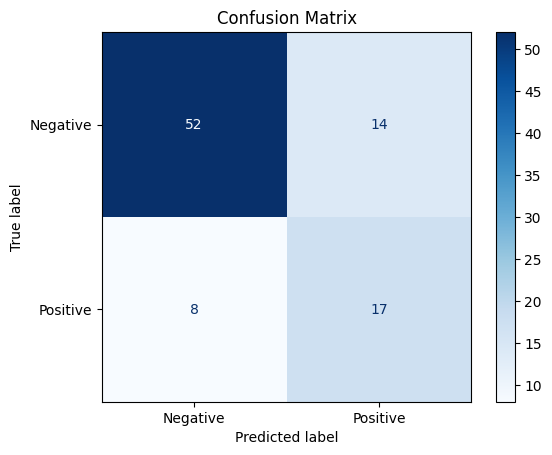


Classification Report:
              precision    recall  f1-score   support

    Negative       0.87      0.79      0.83        66
    Positive       0.55      0.68      0.61        25

    accuracy                           0.76        91
   macro avg       0.71      0.73      0.72        91
weighted avg       0.78      0.76      0.77        91

Number of selected features: 91
Shape of SHAP values: (244, 91)


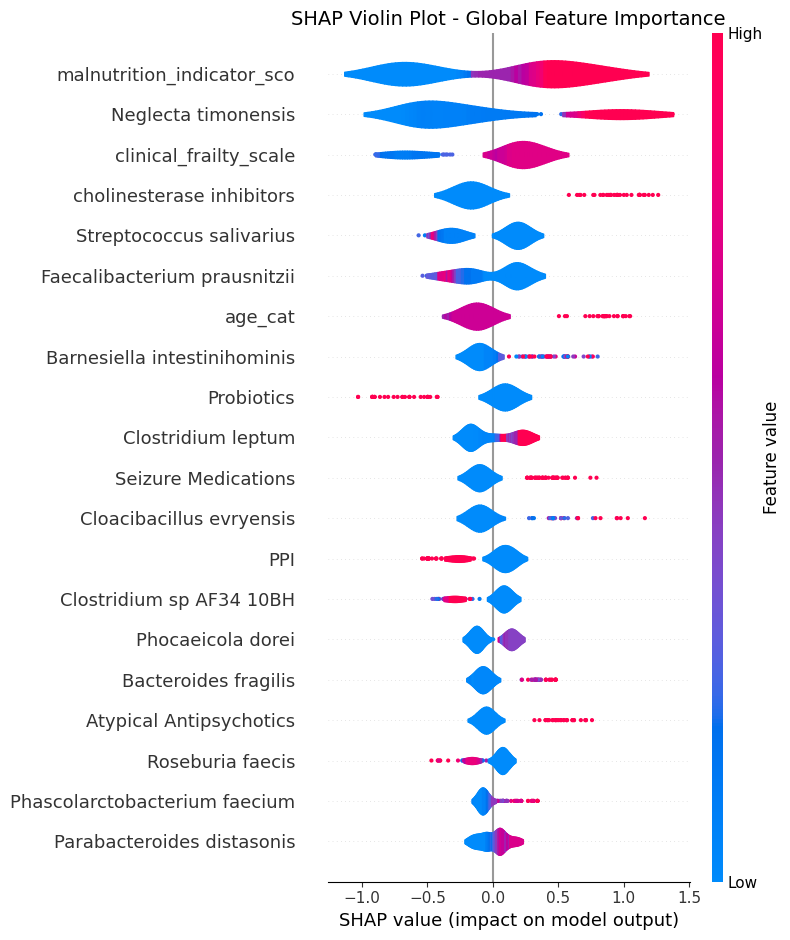

Overlap bacteria found: {'Barnesiella_intestinihominis', 'Clostridium_scindens', 'Enterocloster_clostridioformis', 'Bacteroides_cellulosilyticus', 'Cloacibacillus_evryensis', 'Candidatus_Cibiobacter_qucibialis', 'Streptococcus_salivarius', 'Anaerotignum_lactatifermentans', 'Faecalicatena_fissicatena', 'Methanobrevibacter_smithii', 'Enterocloster_bolteae', 'Alistipes_finegoldii', 'GGB3005_SGB3996', 'GGB32463_SGB47515', 'Sellimonas_intestinalis', 'Clostridiales_bacterium_1_7_47FAA', 'Faecalimonas_umbilicata', 'Dialister_invisus', 'Neglecta_timonensis', 'Ruminococcus_gnavus', 'Bacteroides_uniformis', 'Bacteroides_stercoris', 'Longicatena_caecimuris', 'Clostridia_bacterium', 'Clostridium_sp_AF34_10BH', 'Bilophila_wadsworthia', 'Alistipes_putredinis', 'Ruminococcus_torques', 'Dorea_formicigenerans', 'Parabacteroides_merdae', 'Rikenellaceae_bacterium', 'Limosilactobacillus_fermentum', 'Phocaeicola_vulgatus', 'Escherichia_coli', 'Bacteroides_xylanisolvens', 'Blautia_faecis', 'Clostridium_sp_A

In [14]:
import optuna
from optuna.samplers import TPESampler
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import (
    roc_curve, roc_auc_score, f1_score, accuracy_score, confusion_matrix, 
    classification_report, ConfusionMatrixDisplay
)

from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from sklearn.model_selection import train_test_split
from copy import deepcopy
from sklearn.preprocessing import StandardScaler

# Constants and Configuration
print(f"Experiment number: {experiment_number} | Seed number: {seed}")
# seed = experiment_seed  # Replace with your experiment seed
test_size = 0.25
gpu_device = "hist"

# Function to check for overlaps between train and test data
def check_for_overlap(train_data, test_data):
    """
    Checks for overlapping Sample ID and study_id between train and test datasets.
    """
    # Check for overlapping Study IDs
    overlap_study_ids = set(train_data["study_id"]) & set(test_data["study_id"])
    if overlap_study_ids:
        print(f"Overlap Study ID found: {overlap_study_ids}")
    else:
        print("No overlap Study ID found.")

    # Check for overlapping Sample IDs
    overlap_sample_ids = set(train_data["Sample ID"]) & set(test_data["Sample ID"])
    if overlap_sample_ids:
        print(f"Overlap Sample ID found: {overlap_sample_ids}")
    else:
        print("No overlap Sample ID found.")

def check_for_bacteria(list_a, list_b):
    """
    Checks for overlapping bactertia from list_a and list list_b database and predicted bacteria.
    """
    # Check for overlapping Study IDs
    list_a = [item.replace(" ", "_") for item in list_a]
    list_b = [item.replace(" ", "_") for item in list_b]
    
    overlap_bacteria = set(list_a) & set(list_b)
    if overlap_bacteria:
        print(f"Overlap bacteria found: {overlap_bacteria}")
    else:
        print("No overlap bacteria found.")
    return overlap_bacteria

        
def preprocess_data(df, columns_to_drop, test_size, seed):
    # Split study IDs into train/test sets
    study_labels = df.groupby("study_id")["Alzheimers"].max().reset_index()
    train_ids, test_ids = train_test_split(
        study_labels["study_id"],
        test_size=test_size,
        stratify=study_labels["Alzheimers"],
        random_state=seed,
    )
    
    train_data = df[df["study_id"].isin(train_ids)].copy()
    test_data = df[df["study_id"].isin(test_ids)].copy()

    # Check for overlaps
    check_for_overlap(train_data, test_data)
    
    # Select feature columns
    feature_columns = [col for col in df.columns if col not in columns_to_drop]

    # Convert feature columns to float64 to ensure compatibility
    train_data[feature_columns] = train_data[feature_columns].astype(np.float64)
    test_data[feature_columns] = test_data[feature_columns].astype(np.float64)

    # Normalize the feature columns
    scaler = StandardScaler()
    train_data.loc[:, feature_columns] = scaler.fit_transform(train_data[feature_columns])
    test_data.loc[:, feature_columns] = scaler.transform(test_data[feature_columns])

    return train_data, test_data, feature_columns

# Function to compute class weights
def compute_weights(y_train):
    class_weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
    scale_pos_weight = class_weights[1] / class_weights[0]
    return scale_pos_weight

# Define Optuna Objective Function
def objective(trial, X_train, y_train, scale_pos_weight, seed):
    print(f"Seed in the model {seed} on Device {device}")
    # Feature selection parameters
    threshold = trial.suggest_categorical('threshold', ['median', 'mean', '0.5*mean', '1.5*mean', 'very_low'])
    max_features = trial.suggest_int('max_features', 1, X_train.shape[1])
    norm_order = trial.suggest_int('norm_order', 1, 2)
    threshold_value = -1e10 if threshold == 'very_low' else threshold

    # Feature selection
    selector = SelectFromModel(
        estimator=XGBClassifier(
            objective='binary:logistic',
            eval_metric='logloss',
            scale_pos_weight= scale_pos_weight,
            random_state=seed,
            tree_method=gpu_device, 
            device=device
        ),
        threshold=threshold_value,
        max_features=max_features,
        norm_order=norm_order
    )
    
    selector.fit(X_train, y_train)
    X_train_selected = selector.transform(X_train)

    # Define XGBoost parameters
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5),
        'max_depth': trial.suggest_int('max_depth', 3, 30),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'scale_pos_weight': scale_pos_weight,
        'seed': seed,
        'tree_method': gpu_device,
        'device': device
    }

    # Cross-validation
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=seed)
    f1_scores = []
    for train_idx, val_idx in skf.split(X_train_selected, y_train):
        X_train_fold, X_val_fold = X_train_selected[train_idx], X_train_selected[val_idx]
        y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]
        dtrain = xgb.DMatrix(X_train_fold, label=y_train_fold)
        dval = xgb.DMatrix(X_val_fold, label=y_val_fold)
        model = xgb.train(
            params=params,
            dtrain=dtrain,
            num_boost_round=trial.suggest_int("n_estimators", 50, 300),
            evals=[(dtrain, 'train'), (dval, 'eval')],
            early_stopping_rounds=50,
            verbose_eval=False
        )
        y_val_pred = model.predict(dval)
        y_val_pred_binary = (y_val_pred >= 0.5).astype(int)
        f1_scores.append(f1_score(y_val_fold, y_val_pred_binary))
    return np.mean(f1_scores)

# Main Program
columns_to_drop = ["Sample ID", "study_id", "Alzheimers", "Date Sample", "age", "Dementia Other"] # "malnutrition_indicator_sco", "clinical_frailty_scale", "PPI", 

train_data, test_data, feature_columns = preprocess_data(clinical_microbiome_df, columns_to_drop, test_size, seed)
X_train = deepcopy(train_data[feature_columns].values)
y_train = np.array(train_data["Alzheimers"].values)
X_test = deepcopy(test_data[feature_columns].values)
y_test = np.array(test_data["Alzheimers"].values)
scale_pos_weight = compute_weights(y_train)

# Run Optuna Optimization
study = optuna.create_study(direction="maximize", sampler=TPESampler(seed=seed))
study.optimize(lambda trial: objective(trial, X_train, y_train, scale_pos_weight, seed), n_trials=100)

# Best Parameters
best_params = study.best_params
print("Best Parameters:", best_params)

# Apply Final Model
final_selector = SelectFromModel(
    estimator=XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        random_state=seed,
        tree_method=gpu_device,
        device=device,
        scale_pos_weight=scale_pos_weight
    ),
    
    threshold=-1e10 if best_params['threshold'] == 'very_low' else best_params['threshold'],
    max_features=best_params['max_features'],
    norm_order=best_params['norm_order']
)

final_selector.fit(X_train, y_train)
X_train_selected = final_selector.transform(X_train)
X_test_selected = final_selector.transform(X_test)

# Train Final Model
final_model_params = {
    **{k: v for k, v in best_params.items() if k not in ['threshold', 'norm_order', 'max_features', 'n_estimators']},
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'scale_pos_weight': scale_pos_weight,
    'seed': seed,
    'tree_method': gpu_device,
    'device': device
}

dtrain_final = xgb.DMatrix(X_train_selected, label=y_train)
dtest_final = xgb.DMatrix(X_test_selected)

final_model = xgb.train(
    params=final_model_params,
    dtrain=dtrain_final,
    num_boost_round=best_params['n_estimators'],
)

# Predictions and Evaluation
y_test_pred = final_model.predict(dtest_final)
y_test_pred_binary = (y_test_pred >= 0.5).astype(int)
auc = roc_auc_score(y_test, y_test_pred)
accuracy = accuracy_score(y_test, y_test_pred_binary)
f1 = f1_score(y_test, y_test_pred_binary)
conf_matrix = confusion_matrix(y_test, y_test_pred_binary)

print("\nTest Metrics:")
print(f"ROC AUC: {auc}\nAccuracy: {accuracy}\nF1 Score: {f1}\nConfusion Matrix:\n{conf_matrix}")
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Negative", "Positive"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

report = classification_report(y_test, y_test_pred_binary, target_names=["Negative", "Positive"])
print("\nClassification Report:")
print(report)

# Extract feature names for selected features
selected_feature_names = [feature_columns[i] for i in final_selector.get_support(indices=True)]
print(f"Number of selected features: {len(selected_feature_names)}")

# Step 1: Initialize SHAP explainer
explainer = shap.Explainer(final_model, X_train_selected)

# Step 2: Compute SHAP values
shap_values = explainer(X_train_selected, check_additivity=False)

# Ensure SHAP values are in the correct shape for processing
print(f"Shape of SHAP values: {shap_values.values.shape}")  # Check the shape

# Truncate each feature name to a maximum of 30 characters
max_len = 40
selected_feature_names = [
    feature[:max_len] if len(feature) > max_len else feature  # Truncate if longer than 30 characters
    for feature in selected_feature_names
]

# Verify the selected feature names align with the SHAP values
assert len(selected_feature_names) == X_train_selected.shape[1], "Mismatch in feature names and SHAP input dimensions."

# Generate SHAP summary plot with corrected feature names
plt.figure(figsize=(20, 10))  # Increased width for a wider plot
plt.title("SHAP Violin Plot - Global Feature Importance", fontsize=14)

# Create summary plot with corrected feature names
shap.summary_plot(
    shap_values.values,  # SHAP values
    X_train_selected,  # Input data
    feature_names=selected_feature_names,  # Correct feature names
    max_display=20,  # Limit to top 20 features
    plot_type="violin"  # Violin plot with colors
)
plt.show()

bacteria_fount = check_for_bacteria(bacteria_df.species_name.tolist(),selected_feature_names)

In [15]:
auc

np.float64(0.8290909090909091)

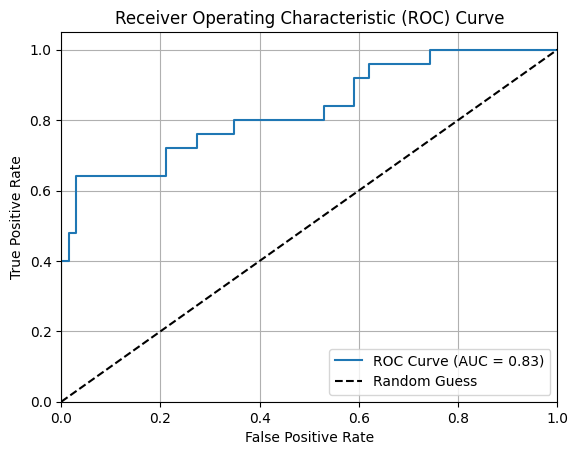

In [16]:
# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')  # Dashed diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [17]:
accuracy

0.7582417582417582

In [18]:
f1

np.float64(0.6071428571428571)

In [19]:
conf_matrix

array([[52, 14],
       [ 8, 17]])

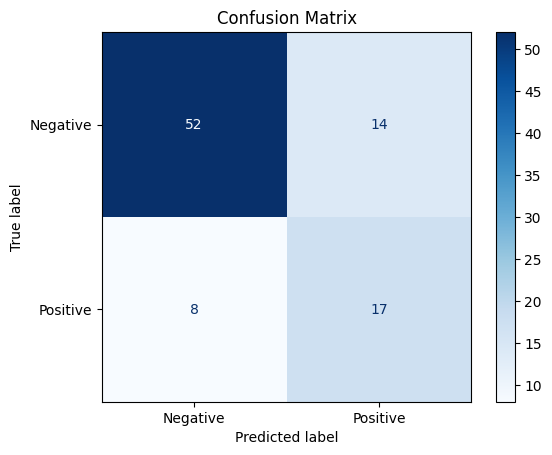

In [20]:
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Negative", "Positive"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

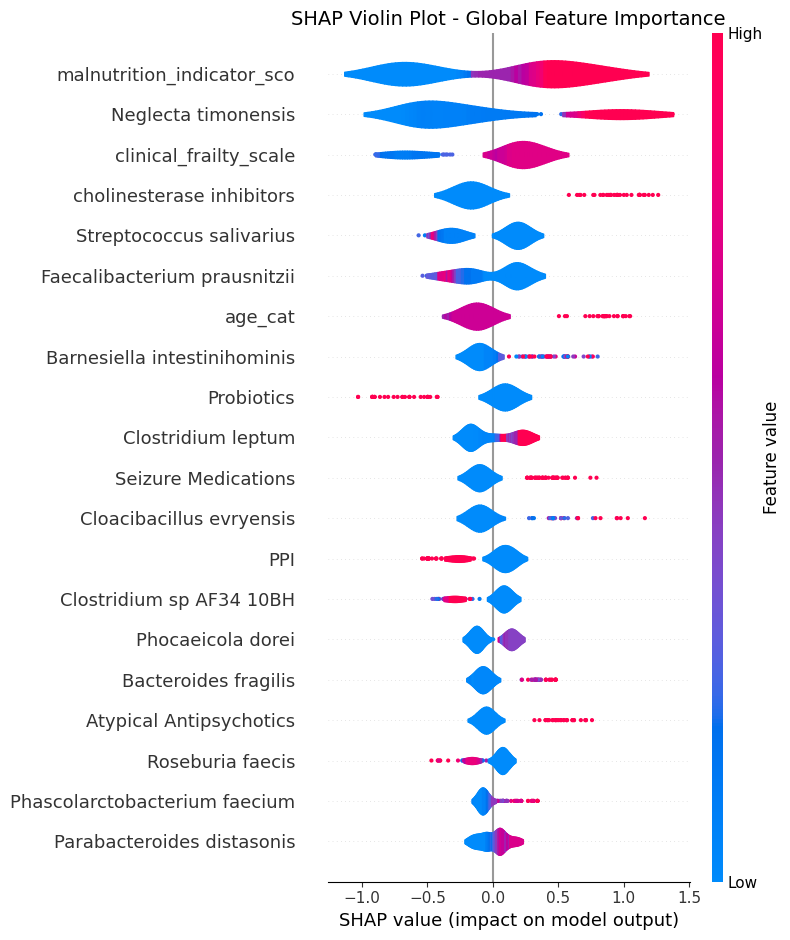

Overlap bacteria found: {'Barnesiella_intestinihominis', 'Clostridium_scindens', 'Enterocloster_clostridioformis', 'Bacteroides_cellulosilyticus', 'Cloacibacillus_evryensis', 'Candidatus_Cibiobacter_qucibialis', 'Streptococcus_salivarius', 'Anaerotignum_lactatifermentans', 'Faecalicatena_fissicatena', 'Methanobrevibacter_smithii', 'Enterocloster_bolteae', 'Alistipes_finegoldii', 'GGB3005_SGB3996', 'GGB32463_SGB47515', 'Sellimonas_intestinalis', 'Clostridiales_bacterium_1_7_47FAA', 'Faecalimonas_umbilicata', 'Dialister_invisus', 'Neglecta_timonensis', 'Ruminococcus_gnavus', 'Bacteroides_uniformis', 'Bacteroides_stercoris', 'Longicatena_caecimuris', 'Clostridia_bacterium', 'Clostridium_sp_AF34_10BH', 'Bilophila_wadsworthia', 'Alistipes_putredinis', 'Ruminococcus_torques', 'Dorea_formicigenerans', 'Parabacteroides_merdae', 'Rikenellaceae_bacterium', 'Limosilactobacillus_fermentum', 'Phocaeicola_vulgatus', 'Escherichia_coli', 'Bacteroides_xylanisolvens', 'Blautia_faecis', 'Clostridium_sp_A

In [21]:
# Verify the selected feature names align with the SHAP values
assert len(selected_feature_names) == X_train_selected.shape[1], "Mismatch in feature names and SHAP input dimensions."

# Generate SHAP summary plot with corrected feature names
plt.figure(figsize=(20, 10))  # Increased width for a wider plot
plt.title("SHAP Violin Plot - Global Feature Importance", fontsize=14)

# Create summary plot with corrected feature names
shap.summary_plot(
    shap_values.values,  # SHAP values
    X_train_selected,  # Input data
    feature_names=selected_feature_names,  # Correct feature names
    max_display=20,  # Limit to top 20 features
    plot_type="violin"  # Violin plot with colors
)
plt.show()

bacteria_fount = check_for_bacteria(bacteria_df.species_name.tolist(),selected_feature_names)

Shape of SHAP values: (244, 91)


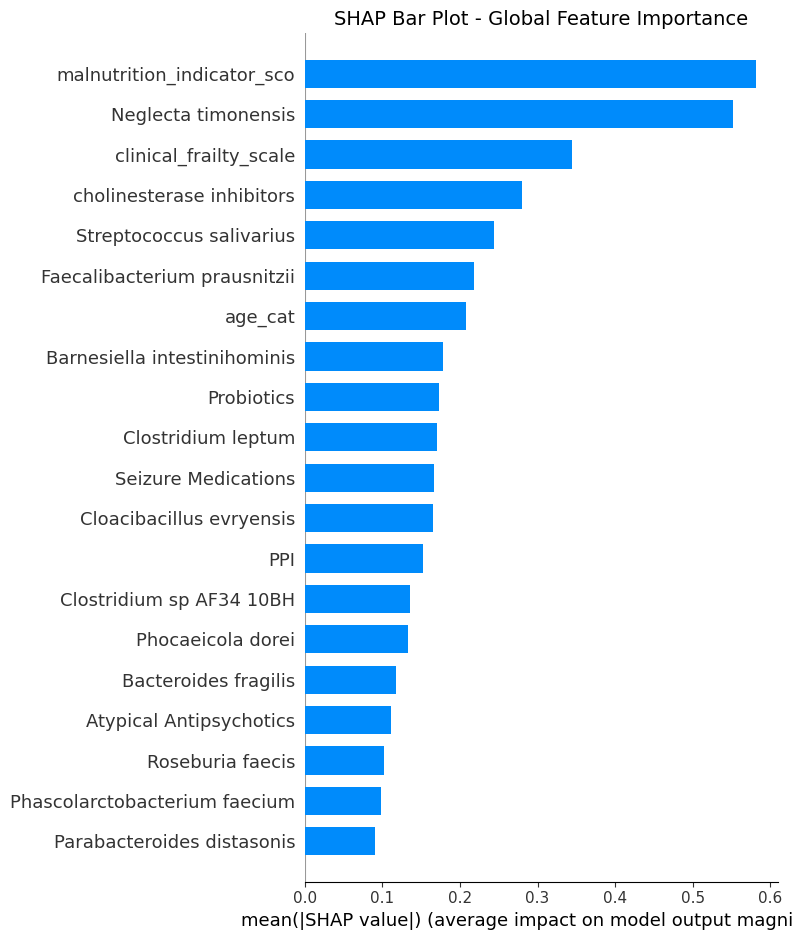

Overlap bacteria found: {'Barnesiella_intestinihominis', 'Clostridium_scindens', 'Enterocloster_clostridioformis', 'Bacteroides_cellulosilyticus', 'Cloacibacillus_evryensis', 'Candidatus_Cibiobacter_qucibialis', 'Streptococcus_salivarius', 'Anaerotignum_lactatifermentans', 'Faecalicatena_fissicatena', 'Methanobrevibacter_smithii', 'Enterocloster_bolteae', 'Alistipes_finegoldii', 'GGB3005_SGB3996', 'GGB32463_SGB47515', 'Sellimonas_intestinalis', 'Clostridiales_bacterium_1_7_47FAA', 'Faecalimonas_umbilicata', 'Dialister_invisus', 'Neglecta_timonensis', 'Ruminococcus_gnavus', 'Bacteroides_uniformis', 'Bacteroides_stercoris', 'Longicatena_caecimuris', 'Clostridia_bacterium', 'Clostridium_sp_AF34_10BH', 'Bilophila_wadsworthia', 'Alistipes_putredinis', 'Ruminococcus_torques', 'Dorea_formicigenerans', 'Parabacteroides_merdae', 'Rikenellaceae_bacterium', 'Limosilactobacillus_fermentum', 'Phocaeicola_vulgatus', 'Escherichia_coli', 'Bacteroides_xylanisolvens', 'Blautia_faecis', 'Clostridium_sp_A

In [22]:
# Ensure SHAP values are in the correct shape for processing
print(f"Shape of SHAP values: {shap_values.values.shape}")  # Check the shape

# Truncate each feature name to a maximum of 30 characters
max_len = 40
selected_feature_names = [
    feature[:max_len] if len(feature) > max_len else feature  # Truncate if longer than 30 characters
    for feature in selected_feature_names
]

# Verify the selected feature names align with the SHAP values
assert len(selected_feature_names) == X_train_selected.shape[1], "Mismatch in feature names and SHAP input dimensions."

# Generate SHAP summary plot with corrected feature names
plt.figure(figsize=(20, 10))  # Increased width for a wider plot
plt.title("SHAP Bar Plot - Global Feature Importance", fontsize=14)

# Create summary plot with corrected feature names
shap.summary_plot(
    shap_values.values,  # SHAP values
    X_train_selected,  # Input data
    feature_names=selected_feature_names,  # Correct feature names
    max_display=20,  # Limit to top 20 features
    plot_type="bar"  # Violin plot with colors
)
plt.show()

bacteria_fount = check_for_bacteria(bacteria_df.species_name.tolist(),selected_feature_names)

In [23]:
measures = ["xgboost", seed, experiment_number, accuracy, auc, f1]

# Create a DataFrame with appropriate column names
columns = ["Model", "Seed", "Experiment_Number", "Accuracy", "AUC", "F1_Score"]
measures_df = pd.DataFrame([measures], columns=columns)
measures_df

,Model,Seed,Experiment_Number,Accuracy,AUC,F1_Score
0,xgboost,135304577,2,0.758242,0.829091,0.607143


In [24]:
output_path = "output"
measures_path = f"{output_path}{os.sep}xgboost_experiment{experiment_number:02d}_measures.csv"
if output_path and not os.path.exists(output_path):
    os.makedirs(output_path)
measures_path

'output/xgboost_experiment02_measures.csv'

In [25]:
measures_df.to_csv(measures_path, index=False)